In [2]:
import argparse
import numpy as np
import pandas as pd
import sys
from scipy.sparse import load_npz, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, brier_score_loss

In [7]:
import json
all_stats = {}
def get_cond_statspath(dataset, sim_src, model, kind, fold_num=0):
    k = "i" if kind == "item" else "s"
    file_path = f"model_stat_store/{dataset}({sim_src})-{model}-{k}-f{fold_num}.json"
    return file_path
    
def set_stats(dataset, sim_src, model, item_stats, skill_stats=None, fold_num=0):
    # Save item stats
    all_stats[(dataset, sim_src, model, 'item')] = item_stats
    with open(get_cond_statspath(dataset, sim_src, model, 'item', fold_num), 'w') as f:
        json.dump(item_stats, f)

    # Save skill stats if available
    if(skill_stats):
        all_stats[(dataset, sim_src, model, 'skill')] = skill_stats
        with open(get_cond_statspath(dataset, sim_src, model, 'skill', fold_num), 'w') as f:
            json.dump(skill_stats, f)

def get_stats(dataset, sim_src, model, kind='item', fold_num=0):
    tup = (dataset, sim_src, model, kind)
    if(tup in all_stats):
        return all_stats[tup]
        
    with open(get_cond_statspath(dataset, sim_src, model, kind, fold_num), 'r') as f:
        stats = json.load(f)
    return stats

def _select(o, selector):
    for sel in selector:
        try:
            o = o[sel]
        except:
            return np.nan
    return o

def _write_stats(o, d, selector):
    for i, sel in enumerate(selector):
        if(i==len(selector)-1):
            o[sel] = d
        else:
            _o = o.get(sel, {})
            o[sel] = _o
            
def _avg_stats(out_stats, all_stats, selector):
    vals = [_select(o, selector) for o in all_stats]
    d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
    _write_stats(out_stats, d, selector)
    
    

def get_kfold_stats(dataset, sim_src, model, kind='item', n_folds=5):
    out_stats = {}
    all_stats = [get_stats(dataset, sim_src, model, kind, fold_num) for fold_num in range(n_folds)]
    _avg_stats(out_stats, all_stats, ['auc'])
    _avg_stats(out_stats, all_stats, ['over_prob'])
    _avg_stats(out_stats, all_stats, ['under_prob'])
    _avg_stats(out_stats, all_stats, ['avg_over_mag'])
    _avg_stats(out_stats, all_stats, ['avg_under_mag'])
    _avg_stats(out_stats, all_stats, ['avg_over'])
    _avg_stats(out_stats, all_stats, ['avg_under'])
    _avg_stats(out_stats, all_stats, ['acc'])
    _avg_stats(out_stats, all_stats, ['nll'])
    _avg_stats(out_stats, all_stats, ['mse'])

    metrics_by_prob = []
    for i, (span, d) in enumerate(all_stats[0]['metrics_by_prob']):
        all_bin_stats = [d] + [all_stats[j]['metrics_by_prob'][i][1] for j in range(1, n_folds)]
        bin_stats = {}
        _avg_stats(bin_stats, all_bin_stats, ['acc'])
        _avg_stats(bin_stats, all_bin_stats, ['nll'])
        _avg_stats(bin_stats, all_bin_stats, ['mse'])
        _avg_stats(bin_stats, all_bin_stats, ['N'])
        _avg_stats(bin_stats, all_bin_stats, ['over_prob'])
        _avg_stats(bin_stats, all_bin_stats, ['under_prob'])
        _avg_stats(bin_stats, all_bin_stats, ['avg_over_mag'])
        _avg_stats(bin_stats, all_bin_stats, ['avg_under_mag'])
        _avg_stats(bin_stats, all_bin_stats, ['avg_over'])
        _avg_stats(bin_stats, all_bin_stats, ['avg_under'])
        metrics_by_prob.append((span, bin_stats))
    out_stats['metrics_by_prob'] = metrics_by_prob
    #print(metrics_by_prob)
    
    return out_stats
       

In [13]:
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ["", "o", "s"]

def plot_metrics_by_prob(dataset, sim_src, models, avg_folds=True, metric="mse"):
    for i, model in enumerate(models):
        kind = "item"
        if(isinstance(model, tuple)):
            model, kind = model
        if(avg_folds):
            stats = get_kfold_stats(dataset, sim_src, model, kind)
            bins, stats_by_prob = zip(*stats["metrics_by_prob"])
            metric_vals = [x[metric]['avg'] for x in stats_by_prob]
            metric_stds = [x[metric]['std'] for x in stats_by_prob]
            plt.errorbar([x[0] for x in bins], metric_vals, yerr=metric_stds, label=model, marker=markers[i],
                         fmt='-', markersize=5, capsize=2, mfc=colors[i]+"aa", mec=colors[i]+"ee")
        else:
            stats = get_stats(dataset, sim_src, model, kind)
            bins, stats_by_prob = zip(*stats["metrics_by_prob"])
            metric_vals = [x[metric] for x in stats_by_prob]
            plt.scatter([x[0] for x in bins], metric_vals, label=model)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel("true probability",fontsize=14)
    plt.title(dataset,fontsize=14)
    plt.xlim(-.05, 1.05)
    plt.legend()
    plt.show()


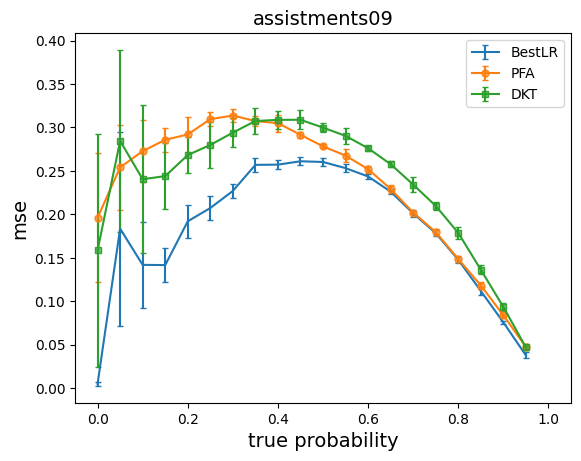

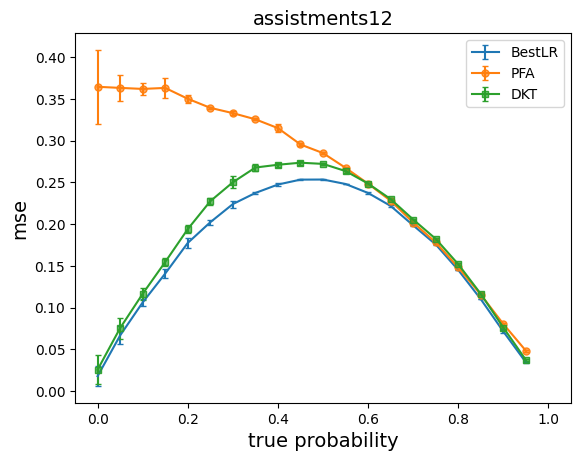

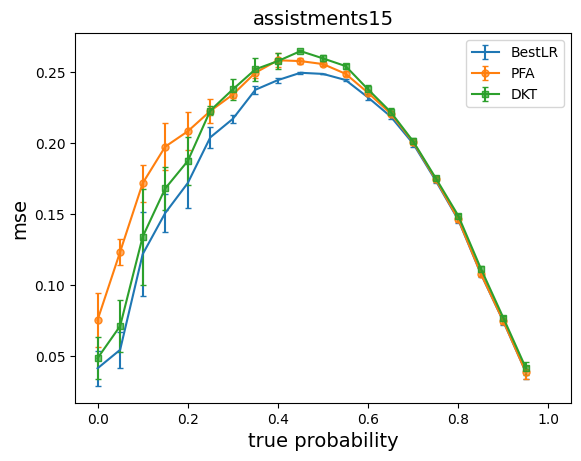

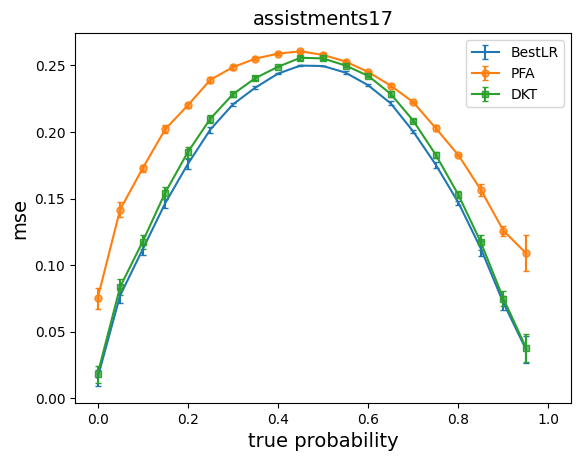

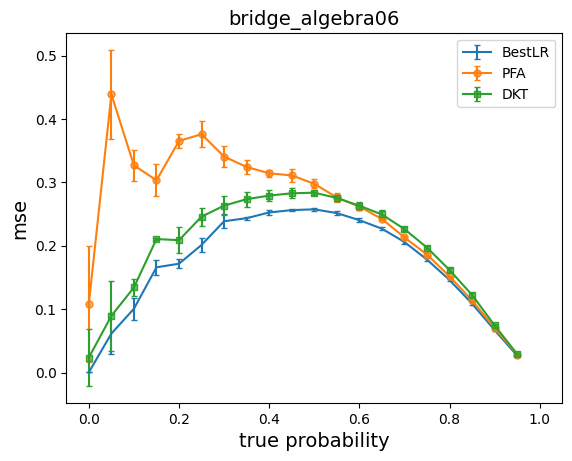

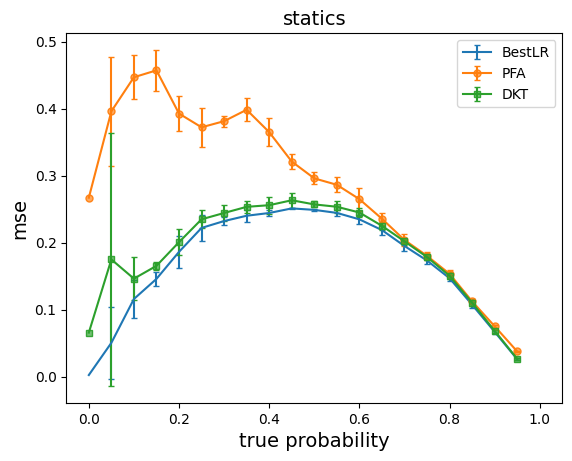

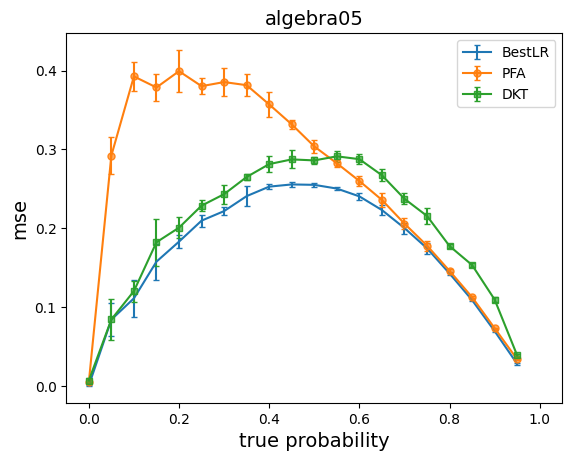

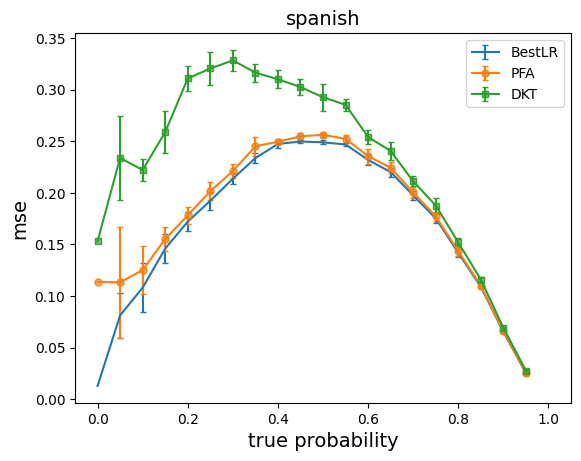

In [14]:
plot_metrics_by_prob('assistments09', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments12', "BestLR", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments15', "BestLR", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments17', "BestLR", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('bridge_algebra06', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('statics', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('algebra05', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('spanish', "BestLR",  ["BestLR", "PFA", "DKT"])

/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}


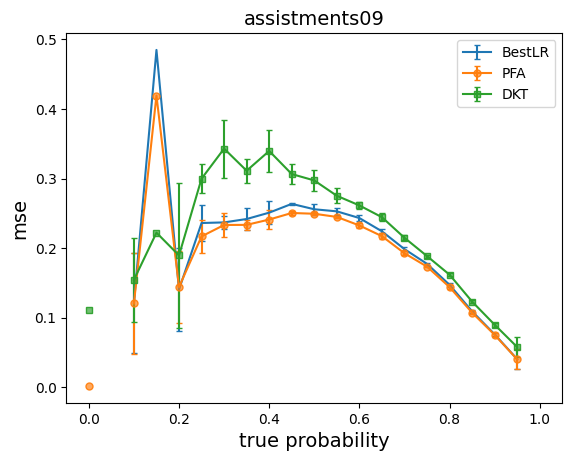

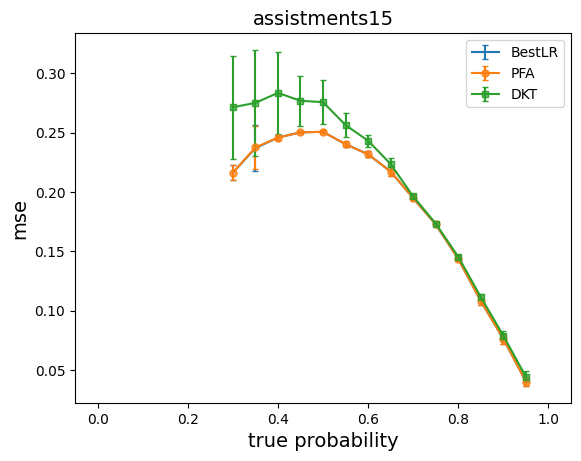

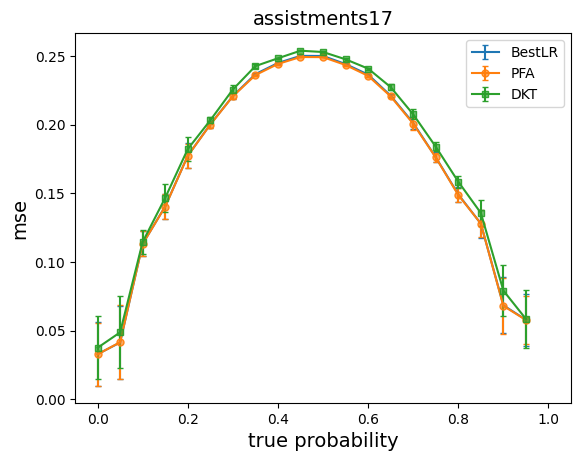

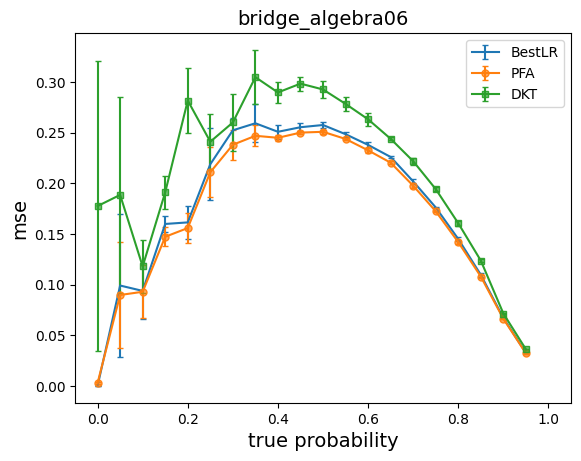

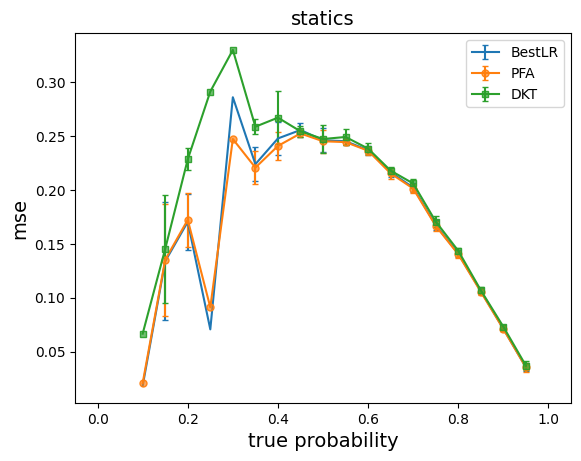

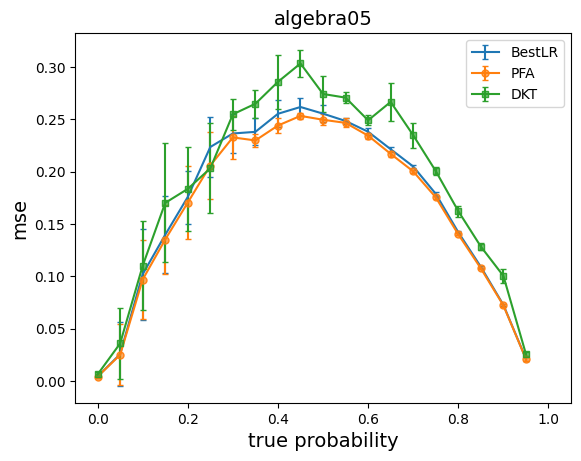

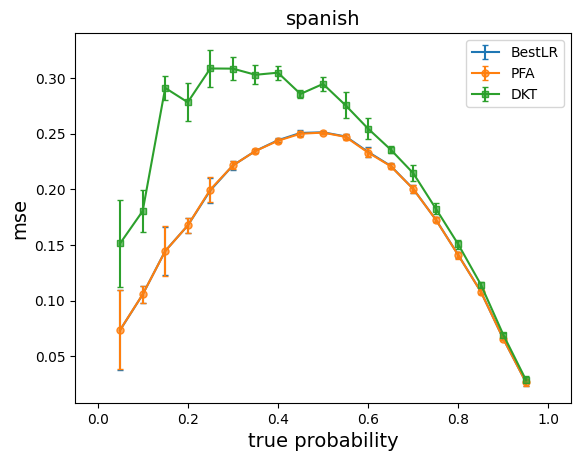

In [12]:
plot_metrics_by_prob('assistments09', "PFA",  ["BestLR", "PFA", "DKT"])
#plot_metrics_by_prob('assistments12', "PFA", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments15', "PFA", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments17', "PFA", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('bridge_algebra06', "PFA",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('statics', "PFA",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('algebra05', "PFA",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('spanish', "PFA",  ["BestLR", "PFA", "DKT"])

In [15]:
from itertools import product
for sim_src in ["real", "BestLR", "PFA"]:
    is_sim = sim_src != "real"
    if(is_sim):
        df = pd.DataFrame(columns=["Dataset", "Model", "Acc", "AUC", "Avg Over+Under", "Avg Over", "Avg Under", ])
    else:
        df = pd.DataFrame(columns=["Dataset", "Model", "Acc", "AUC"])

    #model_stats = []
    for i, (dataset, model) in enumerate(product(['assistments09', 'assistments12', 'assistments15', 'assistments17', 'bridge_algebra06', 'statics', 'algebra05', 'spanish'],
                              ["PFA", "BestLR", ("DKT","item")])):#, ("DKT", "skill")])):

        kind = "item"
        
        if(isinstance(model, tuple)):
            model, kind = model
        k = "" if kind == "item" else "-sk"
        try:
            stats = get_kfold_stats(dataset, sim_src, model, kind)
        except:
            continue
        #print(dataset, model, stats)
        acc = stats.get('acc')
        acc_str = None
        if(acc):
            acc_str = f"{acc['avg']:.3f} ±{acc['std']:.3f}"
        auc_str = f"{stats['auc']['avg']:.3f} ±{stats['auc']['std']:.3f}"


        if(is_sim):
            ov_str = f"{stats['avg_over']['avg']:.3f} ±{stats['avg_over']['std']:.3f}"
            un_str = f"{stats['avg_under']['avg']:.3f} ±{stats['avg_under']['std']:.3f}"
            ou_avg = stats['avg_over']['avg'] + stats['avg_under']['avg']
            ou_std = np.sqrt(stats['avg_over']['std']**2 + stats['avg_under']['std']**2)
            out_str = f"{ou_avg:.3f} ±{ou_std:.3f}"
            
            df.loc[i] = [dataset, f"{model}{k}", acc_str, auc_str, out_str, ov_str, un_str]
        else:
            df.loc[i] = [dataset, f"{model}{k}", acc_str, auc_str]
    print(f"\n Simulation Data (from {sim_src}):" if is_sim else "\n Real Data")
    pd.set_option('display.precision', 3)
    print(df)
    

/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}



 Real Data
Empty DataFrame
Columns: [Dataset, Model, Acc, AUC]
Index: []

 Simulation Data (from BestLR):
             Dataset   Model           Acc           AUC Avg Over+Under  \
0      assistments09     PFA  0.776 ±0.004  0.654 ±0.003   5.370 ±0.160   
1      assistments09  BestLR  0.784 ±0.003  0.712 ±0.003   3.350 ±0.056   
2      assistments09     DKT  0.752 ±0.007  0.635 ±0.003   4.485 ±0.161   
3      assistments12     PFA  0.788 ±0.002  0.643 ±0.002   6.647 ±0.150   
4      assistments12  BestLR  0.800 ±0.002  0.717 ±0.002   3.250 ±0.039   
5      assistments12     DKT  0.792 ±0.003  0.681 ±0.004   4.463 ±0.268   
6      assistments15     PFA  0.763 ±0.003  0.713 ±0.005   2.929 ±0.036   
7      assistments15  BestLR  0.768 ±0.003  0.721 ±0.005   2.405 ±0.041   
8      assistments15     DKT  0.763 ±0.003  0.703 ±0.005   4.304 ±0.165   
9      assistments17     PFA  0.615 ±0.003  0.654 ±0.004   5.234 ±0.242   
10     assistments17  BestLR  0.672 ±0.004  0.734 ±0.004   2.630 ±0.

/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {


 Simulation Data (from PFA):
             Dataset   Model           Acc           AUC Avg Over+Under  \
0      assistments09     PFA  0.791 ±0.001  0.654 ±0.003   3.110 ±0.099   
1      assistments09  BestLR  0.788 ±0.002  0.630 ±0.003   4.244 ±0.116   
2      assistments09     DKT  0.778 ±0.004  0.566 ±0.007   5.760 ±0.309   
3      assistments12     PFA  0.790 ±0.002  0.632 ±0.001   2.975 ±0.195   
4      assistments12  BestLR  0.789 ±0.002  0.618 ±0.002   5.158 ±0.146   
5      assistments12     DKT  0.788 ±0.002  0.582 ±0.003   7.106 ±0.414   
6      assistments15     PFA  0.807 ±0.001  0.659 ±0.002   2.383 ±0.043   
7      assistments15  BestLR  0.807 ±0.001  0.659 ±0.002   2.375 ±0.047   
8      assistments15     DKT  0.806 ±0.001  0.629 ±0.003   4.885 ±0.128   
9      assistments17     PFA  0.603 ±0.001  0.639 ±0.002   3.626 ±0.365   
10     assistments17  BestLR  0.601 ±0.001  0.635 ±0.002   4.806 ±0.425   
11     assistments17     DKT  0.592 ±0.002  0.619 ±0.003   4.781 ±0.41

/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
/tmp/ipykernel_891790/2876374777.py:47: RuntimeWarning: Mean of empty slice
  d = {"avg" : np.nanmean(vals), "std" : np.std(vals)}
